## This is my attempt at implementing the RouBl algorithm

In [43]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
#from tqdm import tqdm

EPS = 1e-5  # define a small constant for numerical stability control

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_std=0.1, init_std=0.1, alpha=0.1, beta=0.01,
                 sqrt_width_scaling=False, device=None, dtype=None, minibatch_size = 0, error = 1e-12, rank_approx = 4):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.beta = beta
        n = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_params = n
        if minibatch_size == 0:
            self.minibatch_size = int(n/10)
        self.error = error
        self.rank_approx = rank_approx

        # define and initialise the trainable variational parameters for q distribtuion
        self.mean = nn.Parameter(torch.zeros(n, **factory_kwargs), requires_grad=True)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_param_std /= self.dim_in ** 0.5
            
        self.prior_std = prior_std

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', torch.zeros(self.num_params, **factory_kwargs))
        self.register_buffer('prior_cov_chol', torch.diag(prior_std*torch.ones(n, **factory_kwargs)).detach().clone().requires_grad_(True))

    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl
    
    
    def fast_inverse(g, U, D, L):
        D_inv = torch.linalg.inv(D)
        I_L = torch.eye(L)
        U_Td_invU =  torch.matmul(torch.matmul(U, D_inv), torch.transpose(U, 0, 1))
        A = torch.linalg.inv(I_L + U_Td_invU)

        UAU_T = torch.matmul(torch.matmul(U, A), torch.transpose(U, 0, 1))
        y = torch.matmul(torch.matmul(D_inv, I_L - torch.matmul(UAU_T,D_inv)), g)

        return y 
    '''def fast_sample(self, mean, U, D, L):
        eps = torch.normal(0,1,size = (self.num_params, 1))
        dinv_0_5 = torch.linalg.inv(D)**0.5
        
        V = dinv_0_5*U

        I = torch.eye(L)
        V_TV = torch.matmul(torch.linalg.inv(V), V)
        A = torch.cholesky(V_TV)

        B = torch.cholesky(I + V_TV)

        A_inv = torch.linalg.inv(A)
        C = torch.matmul(torch.transpose(A_inv, 0, 1), torch.matmul(B - I, A_inv))

        K = torch.linalg.inv(C + V_TV)
        
        y = torch.matmul(dinv_0_5, eps) - torch.matmul(torch.matmul(V, K), torch.matmul(torch.transpose(V, 0, 1), eps))

        return mean + y'''



    def fast_sample(self, mean, U, D, L):
        eps = torch.normal(0,1,size = (self.num_params, 1))
        Dinv = torch.linalg.inv(D)
        Dinv_x = torch.matmul(Dinv, eps)
        I_UDU = torch.linalg.inv(torch.eye(L) + torch.matmul(torch.transpose(U, 0, 1), torch.matmul(Dinv, U)))
        UDinv_x = torch.matmul(torch.transpose(U, 0, 1), Dinv_x)
        
        return mean + Dinv_x - torch.matmul(Dinv, torch.matmul(U, torch.matmul(I_UDU, UDinv_x)))

    def minibatch(self, M, data):
        n = data.size(dim=1)
        p = torch.full(n,1/n)
        index = p.multinomial(num_samples=M)
        return data[index]


    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input
    
    def backprop(M, data_M, theta):
        g = torch.empty(M)
        for i in range(M):
            output = self.forward(data_M[i][0], theta)  # Forward pass with an input from our data in our minibatch
            g[i] = output.backward(torch.ones(output.shape[0]).resize(output.shape[0], 1))  # Backpropagate to calculate gradient 
        return g



    def SLANG(self, data):
        # Initialize 
        L = self.rank_approx
        mean = torch.zeros(self.num_params)
        U = torch.zeros(self.num_params, L)
        D = torch.diag(torch.ones(self.num_params)*self.prior_std)
        print(U,D)
        U_p = torch.zeros(self.num_params, self.num_params)
        D_p = torch.zeros(self.num_params, self.num_params)
        first_loop = True
        lamb = 1/self.prior_std
        delta = 1 - self.beta
        M = self.minibatch_size
        error = self.error

        while torch.linalg.matrix_norm(D + torch.matmul(U, torch.transpose(U, 0, 1)) - (D_p + torch.matmul(U_p, torch.transpose(U_p, 0, 1)))) > error or first_loop:
            first_loop = False
            # generatind a sample from  θ_t ∼ N (θ|µ_t, U_tU_t^T + D_t).
            theta = self.fast_sample(mean, U, D, L)
            # sample a minibatch(I don't know yet if it's sampling a minibatch or N/M minibatchs)
            data_M = self.minibatch(M, data)
            # backprop
            g = self.backprop(data_M, theta)
            # getting the the matrix Q_{1:L}\Lamda_{1:L}^{1/2}
            V = self.Fuck_it_we_ball(delta, U, g, L)
            grad_d = delta*torch.sum(mean**2, 1) + self.beta*torch.sum(g**2, 1) - torch.sum(V**2, 1)

            # updating U and D
            U_p = U 
            D_p = D
            U = V
            D = torch.diag(delta*torch.diagonal(D) + grad_d + lamb)

            g_hat = sum(g) + lamb*mean
            grad_mean = self.fast_inverse(g_hat, U, D)
            mean = mean - self.alpha*grad_mean


        return mean, U, D
    '''
    def fast_eig(delta, U, beta, g, L):
        # From Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositi page 35 see usefull reading
        A = delta*torch.matmul(U, torch.transpose(U)) + beta*g # are approximation is herman 
        Omega = torch.randn(self.num_params)



        return A
    '''
    def r(A,z):
        return torch.matmul(torch.transpose(z, 0, 1),torch.matmul(A, z))/torch.matmul(torch.transpose(z, 0, 1), z)

    def Fuck_it_we_ball(self, delta, U, g, L, error = 1e-6):
        # This is a shifted innvers iteration algorithm
        A = delta*torch.matmul(U, torch.transpose(U, 0, 1)) + self.beta*g # all covariance matrix and are approximations are sym therefor herman 
        U_new = torch.empty(self.num_params, L)
        V = torch.zeros(L, L)
        I = torch.eye(self.num_params)

        for index in range(L):
            k = 0
            e_vector = torch.ones(self.num_params)
            e_value = self.r(A,e_vector)
            s = sum(V)
            while  torch.linalg.matrix_norm(torch.matmul(A, e_vector) - e_value*e_vector ) > error and k < 1000:
                k += 1
                e_vector = torch.linalg.solve(A - s*I, e_vector)
                e_vector = e_vector/torch.linalg.matrix_norm(e_vector)
                e_value = self.r(A,e_vector)
            assert k == 1000, 'Fuck_it_we_ball failed.'
            U_new[index] = e_vector
            V[index] = e_value
        
        return torch.matmul(U_new, torch.daig(V)**0.5)



# Example usage
net = FullCovGaussianNetwork([1, 2, 1], prior_std=0.1, init_std=0.1)
data = torch.tensor(([1.0, 2.0], [1.5, 2.1], [1.01, 2.0]), requires_grad=True)


# Compute the cov wrt the sampled network parameters
mean, U, D = net.SLANG(data.squeeze())





tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000]])


TypeError: full(): argument 'size' (position 1) must be tuple of ints, not int

False


In [ ]:
a = torch.tensor([1,2,3,4])
n = a.size
p = torch.tensor([0.25,0.25,0.25,0.25])
index = p.multinomial(num_samples=3)
print(a[index])

tensor([2, 1, 4])


### Regression Ground Truth & Dataset

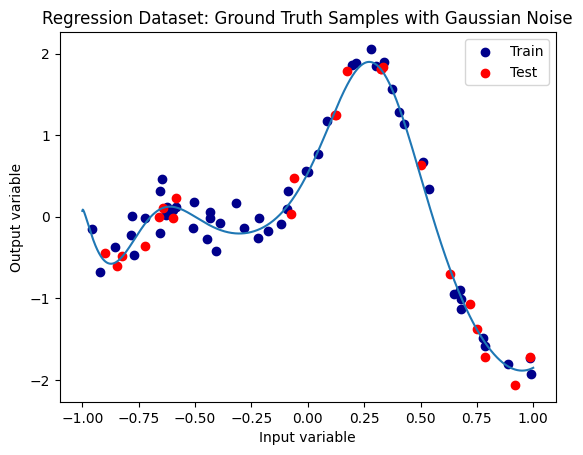

torch.Size([52, 1])

In [ ]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=75, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

y_tr.shape

### Training

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 2

net = FullCovGaussianNetwork([1, 50, 1], prior_std=0.1, init_std=0.1)

sampled_params = net.sample_params()
net.forward(x_tr, sampled_params)


# for epoch in tqdm(range(n_epochs)):
    

tensor([[ 0.0156],
        [ 0.0166],
        [ 0.0065],
        [ 0.0118],
        [ 0.0243],
        [ 0.0184],
        [ 0.0042],
        [ 0.0122],
        [ 0.0157],
        [ 0.0223],
        [-0.0069],
        [ 0.0135],
        [ 0.0086],
        [ 0.0217],
        [ 0.0185],
        [ 0.0233],
        [ 0.0058],
        [ 0.0181],
        [ 0.0186],
        [ 0.0096],
        [ 0.0028],
        [ 0.0214],
        [ 0.0265],
        [ 0.0263],
        [ 0.0109],
        [ 0.0059],
        [ 0.0076],
        [ 0.0112],
        [ 0.0274],
        [ 0.0083],
        [ 0.0274],
        [ 0.0266],
        [ 0.0026],
        [ 0.0281],
        [ 0.0220],
        [ 0.0143],
        [ 0.0284],
        [ 0.0067],
        [ 0.0073],
        [ 0.0277],
        [ 0.0096],
        [ 0.0178],
        [ 0.0030],
        [ 0.0136],
        [ 0.0112],
        [ 0.0288],
        [ 0.0233],
        [ 0.0287],
        [ 0.0061],
        [ 0.0221],
        [-0.0043],
        [ 0.0003]], grad_fn=<Ad